In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import os
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform as trans
import tensorflow as tf
import keras.backend as K
from PIL import Image, ImageOps,ImageEnhance
from keras.models import Model
from keras.layers import Input,MaxPooling2D,UpSampling2D
from keras.layers.convolutional import Conv2D
from keras.layers.merge import concatenate
from keras.layers import BatchNormalization, Activation, Dropout
from keras.optimizers import Adam,Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

class UNet(object):
    def __init__(self,input_shape):
        self.input_shape = input_shape
        self.output_channel_count = 1
        self.firstlayer_filter_count = 64
        self.kernel_initializer = "he_normal"
        self.kernel_size = (3,3)
        self.pool_size = (2,2)
        self.concatenate_axis = 3
        self._create_model()

    def _create_model(self):
        inputs = Input(shape=self.input_shape)

        conv1 = Conv2D(self.firstlayer_filter_count, kernel_size=self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(inputs)
        conv1 = Conv2D(self.firstlayer_filter_count, kernel_size=self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=self.pool_size)(conv1)

        conv2 = Conv2D(self.firstlayer_filter_count*2, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(pool1)
        conv2 = Conv2D(self.firstlayer_filter_count*2, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=self.pool_size)(conv2)
        
        conv3 = Conv2D(self.firstlayer_filter_count*4, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(pool2)
        conv3 = Conv2D(self.firstlayer_filter_count*4, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D(pool_size=self.pool_size)(conv3)

        conv4 = Conv2D(self.firstlayer_filter_count*8, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(pool3)
        conv4 = Conv2D(self.firstlayer_filter_count*8, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv4)
        conv4 = BatchNormalization()(conv4)
        pool4 = MaxPooling2D(pool_size=self.pool_size)(conv4)

        conv5 = Conv2D(self.firstlayer_filter_count*16, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(pool4)
        conv5 = Conv2D(self.firstlayer_filter_count*16, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv5)
        conv5 = BatchNormalization()(conv5)
        pool5 = MaxPooling2D(pool_size=self.pool_size)(conv5)

        bridge = Conv2D(self.firstlayer_filter_count*32, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(pool5)
        bridge = Conv2D(self.firstlayer_filter_count*32, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(bridge)
        bridge = BatchNormalization()(bridge)

        up6 = UpSampling2D(size = self.pool_size)(bridge)
        up6 =  Conv2D(self.firstlayer_filter_count*16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
        merge6 = concatenate([conv5,up6], axis = self.concatenate_axis)
        conv6 = Conv2D(self.firstlayer_filter_count*16, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(merge6)
        conv6 = Conv2D(self.firstlayer_filter_count*16, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv6)
        conv6 = BatchNormalization()(conv6)

        up7 = UpSampling2D(size = self.pool_size)(conv6)
        up7 =  Conv2D(self.firstlayer_filter_count*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
        merge7 = concatenate([conv4,up7], axis = self.concatenate_axis)
        conv7 = Conv2D(self.firstlayer_filter_count*8, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(merge7)
        conv7 = Conv2D(self.firstlayer_filter_count*8, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv7)
        conv7 = BatchNormalization()(conv7)

        up8 = UpSampling2D(size = self.pool_size)(conv7)
        up8 =  Conv2D(self.firstlayer_filter_count*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
        merge8 = concatenate([conv3,up8], axis = self.concatenate_axis)
        conv8 = Conv2D(self.firstlayer_filter_count*4, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(merge8)
        conv8 = Conv2D(self.firstlayer_filter_count*4, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv8)
        conv8 = BatchNormalization()(conv8)

        up9 = UpSampling2D(size = self.pool_size)(conv8)
        up9 =  Conv2D(self.firstlayer_filter_count*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
        merge9 = concatenate([conv2,up9], axis = self.concatenate_axis)
        conv9 = Conv2D(self.firstlayer_filter_count*2, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(merge9)
        conv9 = Conv2D(self.firstlayer_filter_count*2, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv9)
        conv9 = BatchNormalization()(conv9)

        up10 = UpSampling2D(size = self.pool_size)(conv9)
        up10 =  Conv2D(self.firstlayer_filter_count, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up10)
        merge10 = concatenate([conv1,up10], axis = self.concatenate_axis)
        conv10 = Conv2D(self.firstlayer_filter_count, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(merge10)
        conv10 = Conv2D(self.firstlayer_filter_count, kernel_size = self.kernel_size, activation = 'relu', padding = 'same', kernel_initializer = self.kernel_initializer)(conv10)
        conv10 = BatchNormalization()(conv10)

        conv11 = Conv2D(1, kernel_size = (1,1), activation = 'sigmoid')(conv10)

        self.UNET = Model(input=inputs, output=conv11)

    def get_model(self):
        return self.UNET

In [0]:
IMAGE_SIZE = 256
CHANNEL_COUNT = 3
INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,CHANNEL_COUNT)
BATCH_SIZE = 4
NUM_EPOCH = 64
Path =  "/content/drive/My Drive/RUTILEA/SemanticSegmentation2/"
TrainPath = "/content/drive/My Drive/RUTILEA/SemanticSegmentation2/Train" # 訓練画像
TestPath = "/content/drive/My Drive/RUTILEA/SemanticSegmentation2/Test" #テスト画像
TrainLabelPath = "/content/drive/My Drive/RUTILEA/SemanticSegmentation2/TrainLabel" # 訓練画像のラベル
TestLabelPath = "/content/drive/My Drive/RUTILEA/SemanticSegmentation2/TestLabel" # テスト画像のラベル（評価用）
SavePath  = "/content/drive/My Drive/RUTILEA/SemanticSegmentation2/unet_weights.hdf5" # wightを保存するパス

In [0]:
# 標準化(平均を0、分散を1に)
def zscore_standardization(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    return (x-xmean)/xstd

# 正規化(最大値が1,最小値が0)
def min_max_normalization(x, axis=None):
    x_min = x.min(axis=axis, keepdims=True)
    x_max = x.max(axis=axis, keepdims=True)
    return (x-x_min)/(x_max-x_min)

# 値を-1から1に正規化する関数
def normalize_x(image):
    image = image/127.5 - 1
    return image

# 値を0から1に正規化する関数
def normalize_y(image):
    image = image/255
    return image

# 値を0から255に戻す関数
def denormalize_y(image):
    image = image*255
    return image

# インプット画像を読み込む関数
def load_X(folder_path):
    image_files = os.listdir(folder_path)
    image_files.sort()
    LEN = len(image_files)
    images = np.zeros((LEN, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_COUNT), np.float32)

    for i, image_file in enumerate(image_files):
        image = Image.open(folder_path + os.sep + image_file)
        ori_image = image.resize((IMAGE_SIZE,IMAGE_SIZE)).convert("RGB")

        # rgbに変換
        rgb_image = np.asarray(ori_image)

        # canny法でエッジ抽出
        # canny_image = cv2.Canny(np.asarray(ori_image),50,200)[:,:,np.newaxis]

        # images[i] = min_max_normalization(np.concatenate([canny_image,rgb_image],axis=2))
        images[i] = min_max_normalization(rgb_image)
    return images, image_files

# ラベル画像を読み込む関数
def load_Y(folder_path):
    #MEMO: labelmeでアノテーションしたデータはPILじゃないと読み込めない
    image_files = os.listdir(folder_path)
    image_files.sort()
    LEN = len(image_files)
    images = np.zeros((LEN,  IMAGE_SIZE,IMAGE_SIZE,1), np.uint8)

    for i, image_file in enumerate(image_files):
        image = Image.open(folder_path + os.sep + image_file).resize((IMAGE_SIZE,IMAGE_SIZE)).convert("L")
        image = np.asarray(image)
        image = (image!=0)
        images[i] = image[:, : ,np.newaxis]
    return images

In [0]:
# IoU計算
def iou(y_true,y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    intersection = K.sum(y_true * y_pred)
    return intersection / (K.sum(y_true) + K.sum(y_pred) + 1 - intersection)

In [0]:
def augmentation(X_train,Y_train,nums):
    if len(X_train) != len(Y_train):
      raise Exception  
   # nums: 何倍にするか
    data_gen_args = dict(
                        horizontal_flip=True,
                        vertical_flip=True,
                        width_shift_range=0.1,
                        height_shift_range=0.1)
    
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1
    image_generator = image_datagen.flow(
        X_train,
        batch_size = 1,
        seed=seed)
    mask_generator = mask_datagen.flow(
        Y_train,
        batch_size = 1,
        seed=seed)
    
    new_X = []
    new_Y = []
    for _ in range(len(X_train)):
      for _ in range(nums):
        new_X.append(next(image_generator)[0])
        new_Y.append(next(mask_generator)[0])
    new_X = np.concatenate([X_train,np.asarray(new_X)])
    new_Y = np.concatenate([Y_train,np.asarray(new_Y)])
    return new_X,new_Y

In [0]:
# U-Netのトレーニングを実行する関数
def train_unet():
    X_train, _ = load_X(TrainPath)
    Y_train = load_Y(TrainLabelPath)    
    X_train,Y_train = augmentation(X_train,Y_train,9)

    X_test,_ = load_X(TestPath)
    Y_test = load_Y(TestLabelPath)

    # U-Netの生成
    network = UNet(input_shape=INPUT_SHAPE)

    model = network.get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(), 
        metrics=[iou]
    )

    history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH,validation_data=(X_test, Y_test))

    # 重みの保存
    model.save_weights(SavePath)
    return history

In [34]:
history = train_unet()

# 訓練経過の可視化
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.ylabel('iou')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_309 (Conv2D)             (None, 256, 256, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_310 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_309[0][0]                 
__________________________________________________________________________________________________
batch_normalization_122 (BatchN (None, 256, 256, 64) 256         conv2d_310[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`




Train on 400 samples, validate on 10 samples
Epoch 1/64
104/400 [======>.......................] - ETA: 2:08 - loss: 0.6580 - iou: 0.0291

KeyboardInterrupt: ignored

In [0]:
def predict():
    Threshold = 0.5
    X_test, file_names = load_X(TestPath)

    network = UNet(input_shape=INPUT_SHAPE)
    model = network.get_model()
    model.load_weights(SavePath)

    Y_pred = model.predict(X_test, BATCH_SIZE)
    Y_pred = (Y_pred>=Threshold)
    Y_pred = Y_pred.astype(np.uint8)

    # # 保存
    PredictImageSaveFolder = "predict1/"
    for i, y in enumerate(Y_pred):
        img = cv2.imread(TestPath + os.sep + file_names[i])
        y = cv2.resize(y, (img.shape[1], img.shape[0])) 
        basename_without_ext = os.path.splitext(file_names[i])[0]
        cv2.imwrite(Path + PredictImageSaveFolder + 'prediction_' + basename_without_ext + '.png', denormalize_y(y))
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax.imshow(np.squeeze(denormalize_y(Y_pred[1])))
    ax2.imshow(X_test[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


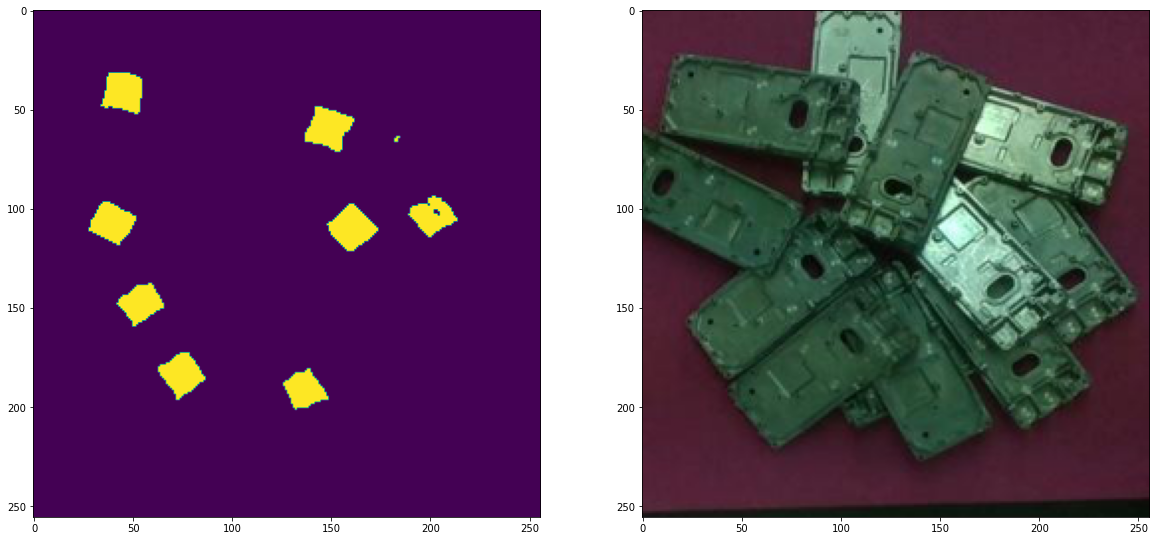

In [36]:
predict()

In [0]:
Threshold = 0.5
KERNELSIZE = 10
MINIMUM_AREA_SIZE = 50 # 領域の面積がこの値以下のものは重心検出しない

def BFS(img):
    """
    予想値の二次元配列から対象領域をBFSで探し,それぞれの領域の重心位置を返す

    Parameters
    ----------
    img : List[List[int]]
        重心検出したい予想値の二次元配列

    Returns
    -------
    G : List[(int,int)]
        各領域の重心座標たち
    """
    # 幅優先探索
    H = img.shape[0] 
    W = img.shape[1]
    isVisited = [[False]*W for _ in range(H)]
    G = []
    li_opening = img.tolist()

    from collections import deque
    for i in range(H):
      for j in range(W):
        if li_opening[i][j] == 0 or isVisited[i][j]:
          continue
        target_rectangle = []
        queue = deque([(i,j)])

        while queue:
          y,x = queue.popleft()
          if 0<=y<H and 0<=x<W:
            if isVisited[y][x]==False and li_opening[y][x]!=0:
              target_rectangle.append((y,x))
              isVisited[y][x] = True

              for dy,dx in [(0,1),(0,-1),(1,0),(-1,0)]:
                  queue.append((y+dy,x+dx))
        
        if len(target_rectangle) <= MINIMUM_AREA_SIZE:
          continue

        sum_i = 0
        sum_j = 0
        for y,x in target_rectangle:
          sum_i += y
          sum_j += x
        G.append((sum_i//len(target_rectangle),sum_j//len(target_rectangle)))
        
    return G

In [0]:
def find_center_of_gravity(img_path: str):
    """
    ダイカストの正方形領域の重心位置を返す.またその重心位置をプロット

    Parameters
    ----------
    img_path : str
        予想したいダイカスト画像の保存先のパス
    
    Returns
    -------
    G : List[(int,int)]
        各領域の重心座標たち
    """
    ori_image = Image.open(img_path)
    image = ori_image.resize((IMAGE_SIZE,IMAGE_SIZE))
    ori_image = np.asarray(ori_image)

    rgb_image = np.asarray(image.convert("RGB"))
    image = min_max_normalization(rgb_image)
    image = image[np.newaxis,:,:,:]

    network = UNet(input_shape=INPUT_SHAPE)
    model = network.get_model()
    model.load_weights(SavePath) 

    pred = model.predict(image, BATCH_SIZE)
    pred = (pred>=Threshold).astype(np.uint8)[0]
    pred = cv2.resize(pred, (ori_image.shape[1], ori_image.shape[0])) 

    kernel = np.ones((KERNELSIZE,KERNELSIZE),np.uint8)

    # モルフォロジー変換のオープニング処理を施す
    # 参考: http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

    # opening = cv2.morphologyEx(pred, cv2.MORPH_OPEN, kernel)
    G = BFS(pred)

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax.imshow(ori_image)
    for y,x in G:
      ax.plot(x,y,color='r',marker='.',markersize=20)
    ax2.imshow(pred)

    return G

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


[(45, 94), (139, 174), (146, 235), (199, 97), (227, 146)]


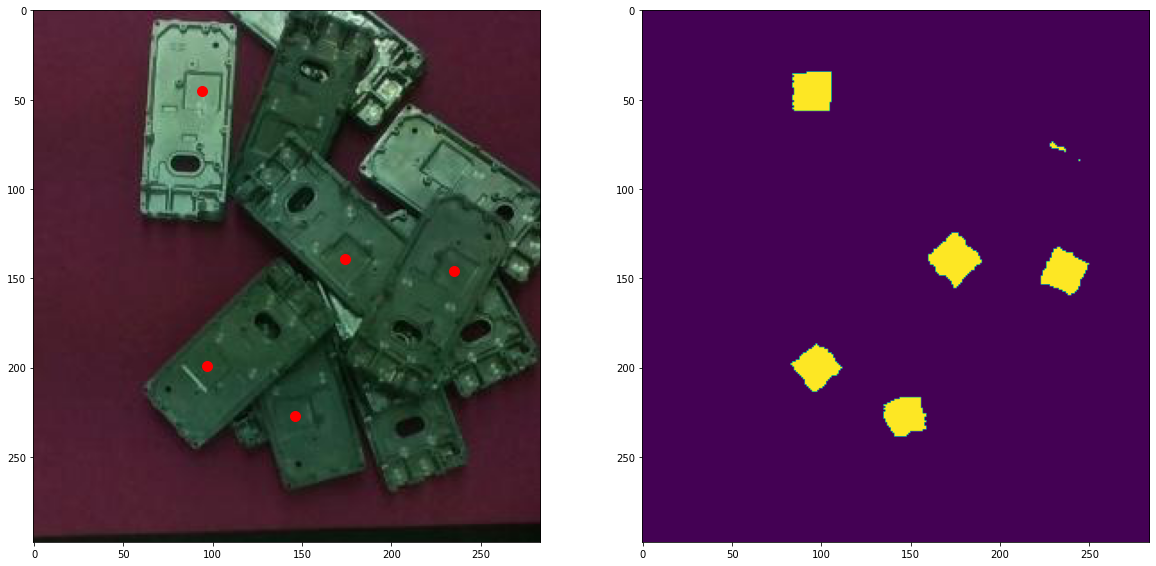

In [30]:
print(find_center_of_gravity(Path+'Test/img43.png'))